In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import re
import os
import random
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K

In [2]:
### READ DATA AND CREATE FEATURES FOR year, month, day, hour ###
df = pd.read_csv('nyc_taxi.csv')

date = pd.DataFrame(np.vstack(df.timestamp.apply(lambda x: re.sub(r':|-' ,' ', x).split()))[:,:4].astype(int))

df = pd.concat([df, date], axis=1)
df.columns = ['timestamp','value','yr','mt','d','H']
df.head()

print(df.shape)
df.head()

(10320, 6)


,timestamp,value,yr,mt,d,H
0,2014-07-01 00:00:00,10844,2014,7,1,0
1,2014-07-01 00:30:00,8127,2014,7,1,0
2,2014-07-01 01:00:00,6210,2014,7,1,1
3,2014-07-01 01:30:00,4656,2014,7,1,1
4,2014-07-01 02:00:00,3820,2014,7,1,2


(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 <a list of 8 Text xticklabel objects>)

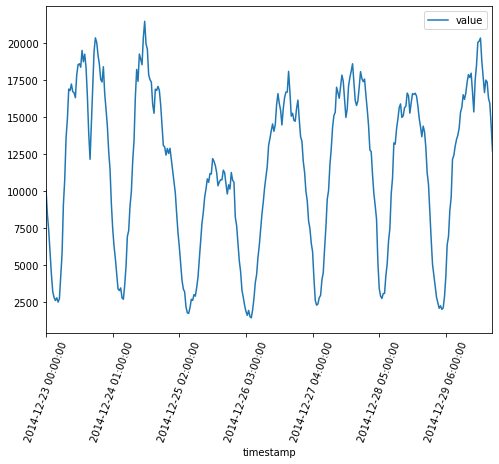

In [3]:
### PLOT SAMPLE OF DATA ###
df.iloc[8400:8400+7*48,:].plot(y='value',x='timestamp',figsize=(8,6))
plt.xticks(rotation=70)

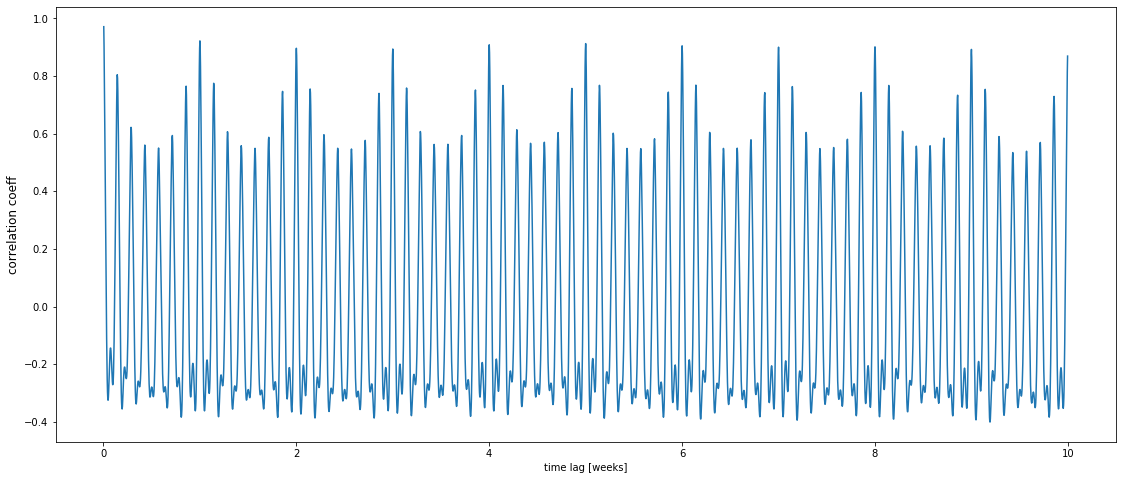

In [4]:
### WEEKLY AUTOCORR PLOT (10 WEEKS DEPTH) ###
timeLags = np.arange(1,10*48*7)
autoCorr = [df.value.autocorr(lag=dt) for dt in timeLags]

plt.figure(figsize=(19,8))
plt.plot(1.0/(48*7)*timeLags, autoCorr);
plt.xlabel('time lag [weeks]'); plt.ylabel('correlation coeff', fontsize=12);

In [5]:
### CREATE WEEKDAY FEATURE AND COMPUTE THE MEAN FOR WEEKDAYS AT EVERY HOURS ###
weekday = df[['yr', 'mt', 'd']].apply(lambda x: datetime.datetime(x['yr'], x['mt'], x['d']).weekday(),axis=1).values

df['weekday'] = weekday
df['weekday_hour'] = df.weekday.astype(str) +' '+ df.H.astype(str)
df['m_weekday'] = df.weekday_hour.replace(df[:5000].groupby('weekday_hour')['value'].mean().to_dict())

In [6]:
### CREATE GENERATOR FOR LSTM ###
sequence_length = 48

def gen_index(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

In [7]:
### CREATE AND STANDARDIZE DATA FOR LSTM ### 
cnt, mean = [], []
for sequence in gen_index(df, sequence_length, ['value']):
    cnt.append(sequence)
    
for sequence in gen_index(df, sequence_length, ['m_weekday']):
    mean.append(sequence)

cnt, mean = np.log(cnt), np.log(mean)
cnt = cnt - mean
cnt.shape

(10272, 48, 1)

In [8]:
### CREATE AND STANDARDIZE LABEL FOR LSTM ###
init = df.m_weekday[sequence_length:].apply(np.log).values
label = df.value[sequence_length:].apply(np.log).values - init
label.shape

(10272,)

In [9]:
### DEFINE QUANTILE LOSS ###
def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [10]:
### TRAIN TEST SPLIT ###
X_train, X_test = cnt[:5000], cnt[5000:]
y_train, y_test = label[:5000], label[5000:]

In [11]:
### SET SEED ###
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


### CREATE MODEL ###
losses = [lambda y,f: q_loss(0.1,y,f), lambda y,f: q_loss(0.5,y,f), lambda y,f: q_loss(0.9,y,f)]

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)
dense = Dense(50)(lstm)
out10 = Dense(1)(dense)
out50 = Dense(1)(dense)
out90 = Dense(1)(dense)

model = Model(inputs, [out10,out50,out90])
model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])

In [12]:
history = model.fit(X_train, [y_train,y_train,y_train], epochs=50, batch_size=128, verbose=2, shuffle=True)

Train on 5000 samples
Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5000/5000 - 16s - loss: 0.0288 - dense_1_loss: 0.0296 - dense_2_loss: 0.0450 - dense_3_loss: 0.0245
Epoch 2/50
5000/5000 - 6s - loss: 0.0257 - dense_1_loss: 0.0236 - dense_2_loss: 0.0413 - dense_3_loss: 0.0215
Epoch 3/50
5000/5000 - 6s - loss: 0.0252 - dense_1_loss: 0.0222 - dense_2_loss: 0.0404 - dense_3_loss: 0.0212
Epoch 4/50
5000/5000 - 6s - loss: 0.0248 - dense_1_loss: 0.0217 - dense_2_loss: 0.0396 - dense_3_loss: 0.0206
Epoch 5/50
5000/5000 - 6s - loss: 0.0239 - dense_1_loss: 0.0205 - dense_2_loss: 0.0388 - dense_3_loss: 0.0204
Epoch 6/50
5000/5000 - 7s - loss: 0.0238 - dense_1_loss: 0.0205 - dense_2_loss: 0.0383 - dense_3_loss: 0.0197
Epoch 7/50
5000/5000 - 5s - loss: 0.0230 - dense_1_loss: 0.0197 - dense_2_loss: 0.0370 - dense_3_loss: 0.0191
Epoch 8/50
5000/5000 - 5s - loss: 0.0225 - dense_1_loss: 0.0199 - dense_2_loss: 0.0369 - dense_3_loss: 0.0191
Epo

In [14]:
### QUANTILEs BOOTSTRAPPING ###
pred_10, pred_50, pred_90 = [], [], []
NN = K.function([model.layers[0].input], 
                [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    predd = NN([X_test, 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:06<00:00,  3.67s/it]


In [15]:
### REVERSE TRANSFORM PREDICTIONS ###
pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init[5000:])
pred_50_m = np.exp(pred_50.mean(axis=0) + init[5000:])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init[5000:])

In [16]:
### EVALUATION METRIC ###
mean_squared_log_error(np.exp(y_test + init[5000:]), pred_50_m)

0.0681386084050362

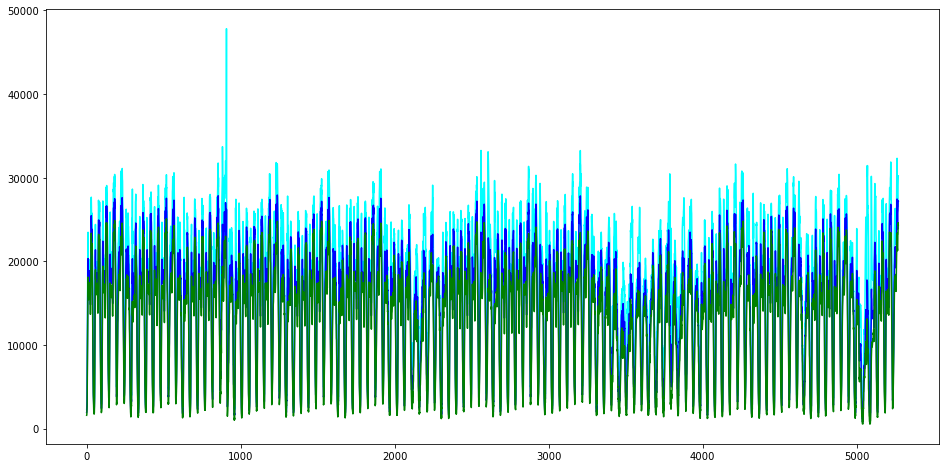

In [17]:
### PLOT QUANTILE PREDICTIONS ###
plt.figure(figsize=(16,8))
plt.plot(pred_90_m, color='cyan')
plt.plot(pred_50_m, color='blue')
plt.plot(pred_10_m, color='green')

### CROSSOVER CHECK ###
plt.scatter(np.where(np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m))[0], 
            pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)], c='red', s=50)

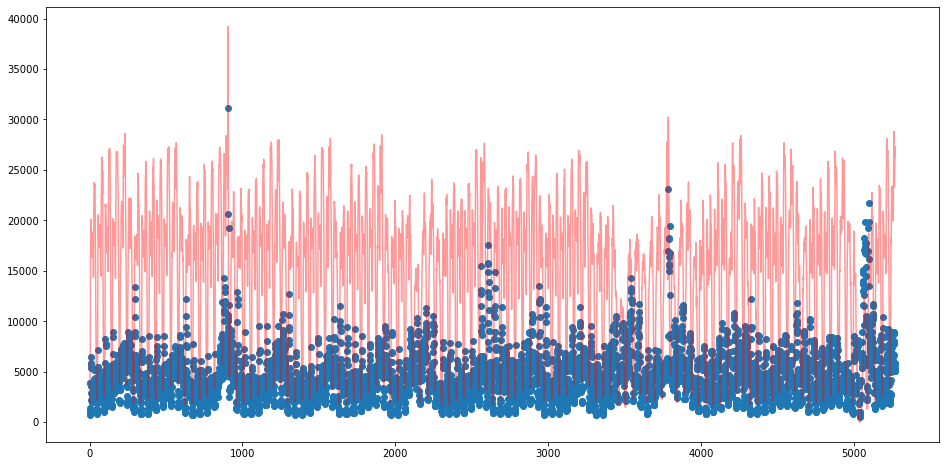

In [18]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###
plt.figure(figsize=(16,8))
plt.plot(np.exp(y_test + init[5000:]), color='red', alpha=0.4)
plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m)